## Analysis of how length of CoT output influences performance

___


In [68]:
import json
import numpy as np
import os
from scripts.utils import count_word_multilingual, sort_files, split_by_analysis

In [137]:
# count_word_multilingual is now imported from scripts.utils

In [138]:
# OUTPUT FORMAT

d = {
    "Task Name": '',
    "Model Name": '',
    "Number of Tokens": [],

}


In [ ]:
import os
import re

def sort_files(files_list):

    num_re = re.compile(r"^(\d+)")  # capture 1+ digits at start

    def leading_num(fname):
        m = num_re.match(fname)
        if m:
            return int(m.group(1))
        else:
            return float("inf")  # or 0, depending on where you want no‑number files

    sorted_files = sorted(files_list, key=leading_num)
    
    return sorted_files

import re
from typing import Any, Optional, Tuple

def split_by_analysis(
    instructions: str,
    prediction: str,
    record_id: Any
) -> Tuple[str, Optional[str], Any]:
    """
    Split a model’s output into (analysis, result) based on markers.

    Tries, in order:
    1. Splitting on the literal "Result:" in the prediction.
    2. Deriving the result label from instructions (e.g. "Result: XYZ:"),
       then splitting on "XYZ:" in the prediction.
    Falls back to returning the whole prediction as analysis with result=None.
    """
    # Should first split by <think>


    # 1) Try literal "Result:" in prediction
    try:
        analysis, result = prediction.split("Result:", 1)
        return analysis.strip(), result.strip(), record_id
    except ValueError:
        pass  # no "Result:" marker in prediction

    # 2) Derive the label from instructions, e.g. instructions contains "Result: XYZ:"
    match = re.search(r"Result:\s*([^:\s]+):", instructions)
    if match:
        label = match.group(1)
        marker = f"{label}:"
        try:
            analysis, result = prediction.split(marker, 1)
            return analysis.strip(), result.strip(), record_id
        except ValueError:
            pass

    # 3) Fallback
    return prediction.strip(), None, record_id

        


In [142]:
i = 0

root_dir = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/result_1"

output = {}

# print(os.listdir(root_dir))
all_folders = sort_files(os.listdir(root_dir))

all_folders = all_folders[16:]

all_results = []
for task_name in all_folders:
    print("On task:", task_name)
    
    # task_path = path to folder with name of the task
    task_path = os.path.join(root_dir, task_name)

    if not os.path.isdir(task_path):
        continue

    # Iterates through each model (subfolder in task folder)
    for model_name in os.listdir(task_path):
        model_path = os.path.join(task_path, model_name)
        if not os.path.isdir(model_path):
            continue

        # Iterates through each OUTPUT FILE in each model's folder
        for fname in os.listdir(model_path):
            # Use ONLY CoT files
            if "-cot-" not in fname:
                continue

            # Load the model output file
            file_path = os.path.join(model_path, fname)
            # with open(file_path, "r") as f:
            #     data = json.load(f)

            file_path = os.path.join(model_path, fname)
            with open(file_path, "r") as f:
                content = f.read()
                if not content.strip():  # empty or just whitespace
                    print(f"Skipping empty file: {file_path}")
                    continue
                data = json.loads(content)

            # Should do average number of tokens for each dataset + model pair

            # Iterate through every output of the dataset
            # 1. Get the total number of tokens used for this dataset via this model
            total_num_tokens = 0
            # print("task name:", task_name, "model name:", model_name, "avg num tokens:", avg_num_tokens)

            for d in data:
                # _, num_tokens = count_word_multilingual(d["pred"])
                analysis, _, id = split_by_analysis(d['instruction'], d['pred'], d['id'])

                _, num_tokens = count_word_multilingual(analysis)
                
                total_num_tokens += num_tokens

            avg_num_tokens = round(total_num_tokens / len(data), 2)
            output[i] = {
                "Task Name": task_name,
                "Model Name": model_name,
                "Avg Number of Tokens": avg_num_tokens
            }

            i += 1


# path where you want to save the file
out_path = "revised_results_0.json"

with open(out_path, "w") as f:
    # indent for readability; sort_keys if you want alphabetical ordering
    json.dump(output, f, indent=4)

print(f"Wrote {len(output)} entries to {out_path}")

On task: 12.C-EMRS
On task: 17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM


KeyboardInterrupt: 

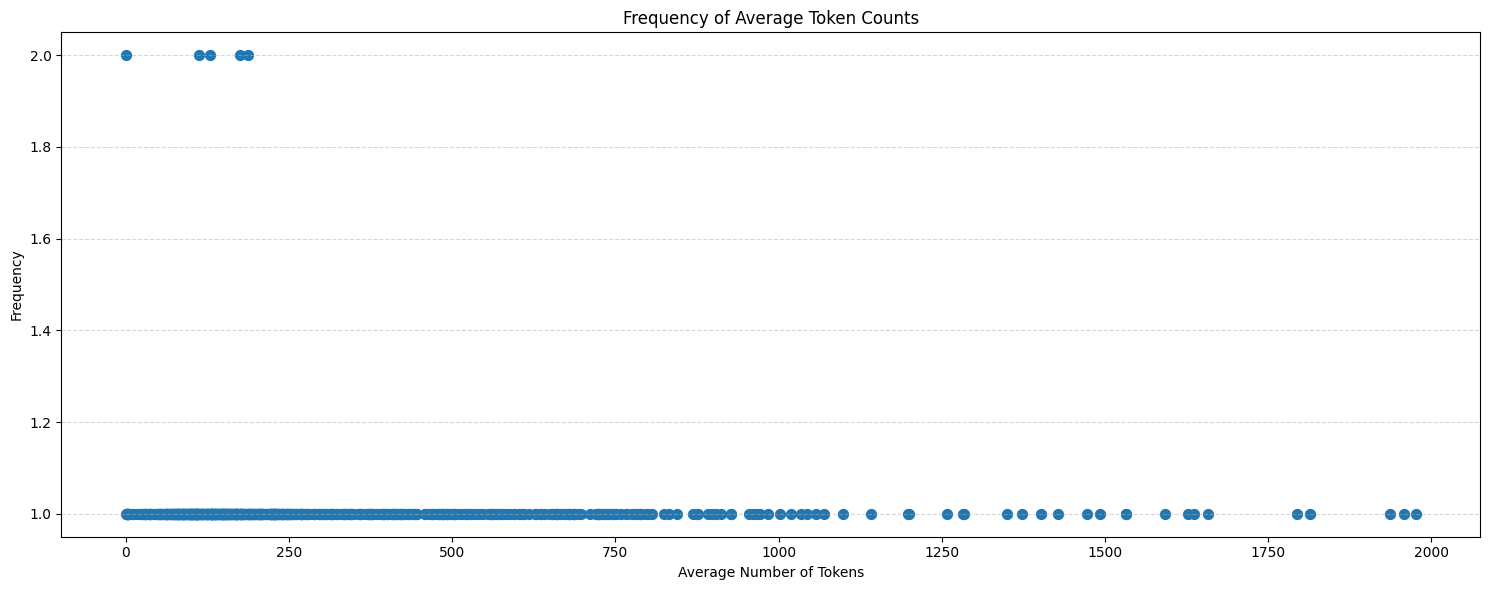

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume your `output` dict is already defined in the environment, e.g.:
# output = {
#     0: {"Task Name": "Task A", "Model Name": "Model X", "Avg Number of Tokens": 120},
#     1: {"Task Name": "Task B", "Model Name": "Model Y", "Avg Number of Tokens": 95},
#     # … more entries …
# }

# 1. Convert the output dict into a DataFrame
df = pd.DataFrame.from_dict(output, orient='index')

# 2. Compute the frequency of each average token count
freq = df["Avg Number of Tokens"].value_counts().sort_index()

# 3. Plot a dotplot (number of tokens on x‑axis, frequency on y‑axis)
plt.figure(figsize=(15, 6))
plt.scatter(freq.index, freq.values, s=50)      # s=dot size, adjust as needed
plt.xlabel("Average Number of Tokens")
plt.ylabel("Frequency")
plt.title("Frequency of Average Token Counts")
plt.grid(axis='y', linestyle='--', alpha=0.5)   # optional grid for readability
plt.tight_layout()
plt.show()


In [139]:
df['range'] = pd.cut(df['Avg Number of Tokens'], bins=range(0, 1700, 200))


In [140]:
df['Avg Number of Tokens'].describe()


count     752.000000
mean      318.262247
std       315.441819
min         0.000000
25%       115.842500
50%       203.320000
75%       421.575000
max      1975.990000
Name: Avg Number of Tokens, dtype: float64

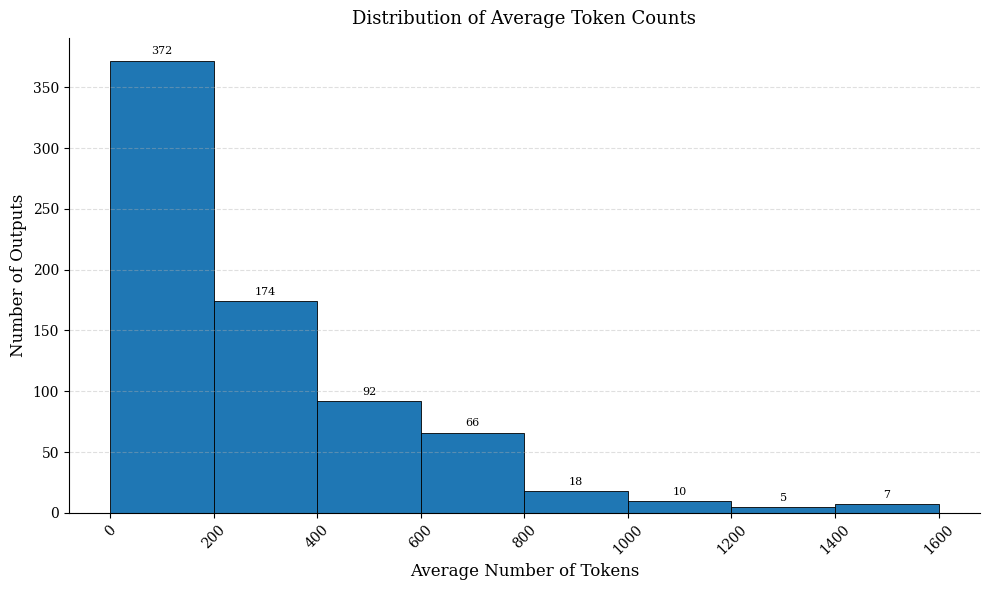

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert output to DataFrame
df = pd.DataFrame.from_dict(output, orient='index')

# Define bins
bins = list(range(0, 1701, 200))

# Set general style
plt.rcParams.update({
    "font.family": "serif",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

# Publication‑ready blue
blue = '#1f77b4'

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with uniform blue bars
bars = ax.hist(
    df["Avg Number of Tokens"],
    bins=bins,
    edgecolor='black',
    color=blue,
    linewidth=0.6
)

# Add exact count labels
ax.bar_label(ax.containers[0], padding=3, fontsize=8)

# Aesthetic improvements
ax.set_xlabel("Average Number of Tokens")
ax.set_ylabel("Number of Outputs")
ax.set_title("Distribution of Average Token Counts", fontsize=13, pad=10)

# Clean up spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='out')

# Grid for readability
ax.grid(axis='y', linestyle='--', alpha=0.4)

# X-axis ticks
ax.set_xticks(bins)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


___

### Task Name to Simplified Name Mapping

___

In [119]:
sheet = pd.ExcelFile("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/Clinical Benchmark and LLM.xlsx")
data = sheet.parse("Task-all")

simplified_name_mapping = {} ## Maps original name --> simplified name

for row_idx, original_name in enumerate(data["Task-Original"]):
    simplified_name_mapping[original_name] = data["Task name"][row_idx]

simplified_name_mapping

{'1-1.ADE-ADE identification': 'ADE-Identification',
 '1-2.ADE-ADE relation': 'ADE-Extraction',
 '1-3.ADE-Drug dosage': 'ADE-Drug dosage',
 '3-2.BARR2-resolution': 'BARR2',
 '5.BrainMRI-AIS': 'BrainMRI-AIS',
 '6.Brateca.hospitalization': 'Brateca-Hospitalization',
 '6.Brateca.mortality': 'Brateca-Mortality',
 '7.Cantemist.CODING': 'Cantemist-Coding',
 '7.Cantemist.NER': 'Cantemis-NER',
 '7.Cantemist.Norm': 'Cantemis-Norm',
 '8.CARES.area': 'CARES-Area',
 '8.CARES.icd10_block': 'CARES ICD10 Block',
 '8.CARES.icd10_chapter': 'CARES-ICD10 Chapter',
 '8.CARES.icd10_sub_block': 'CARES-ICD10 Subblock',
 '9.CHIP-CDEE': 'CHIP-CDEE',
 '12.C-EMRS': 'C-EMRS',
 '17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM': 'CodiEsp-ICD-10-CM',
 '17-2.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-PCS': 'CodiEsp-ICD-10-PCS',
 '19.ClinicalNotes-UPMC': 'ClinicalNotes-UPMC',
 '20.clinical records from the Mexican Social Security Institute': 'PPTS',
 '21.CLINpt': 'CLINpt-NER',
 '22.CLIP': 'CLIP',
 '23.cMedQA': 'cMedQA',


In [120]:
simplified_name_mapping = {'1-1.ADE-ADE identification': 'ADE-Identification',
 '1-2.ADE-ADE relation': 'ADE-Extraction',
 '1-3.ADE-Drug dosage': 'ADE-Drug dosage',
 '3-2.BARR2-resolution': 'BARR2',
 '5.BrainMRI-AIS': 'BrainMRI-AIS',
 '6.Brateca.hospitalization': 'Brateca-Hospitalization',
 '6.Brateca.mortality': 'Brateca-Mortality',
 '7.Cantemist.CODING': 'Cantemist-Coding',
 '7.Cantemist.NER': 'Cantemis-NER',
 '7.Cantemist.Norm': 'Cantemis-Norm',
 '8.CARES.area': 'CARES-Area',
 '8.CARES.icd10_block': 'CARES ICD10 Block',
 '8.CARES.icd10_chapter': 'CARES-ICD10 Chapter',
 '8.CARES.icd10_sub_block': 'CARES-ICD10 Subblock',
 '9.CHIP-CDEE': 'CHIP-CDEE',
 '12.C-EMRS': 'C-EMRS',
 '17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM': 'CodiEsp-ICD-10-CM',
 '17-2.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-PCS': 'CodiEsp-ICD-10-PCS',
 '19.ClinicalNotes-UPMC': 'ClinicalNotes-UPMC',
 '20.clinical records from the Mexican Social Security Institute': 'PPTS',
 '21.CLINpt': 'CLINpt-NER',
 '22.CLIP': 'CLIP',
 '23.cMedQA': 'cMedQA',
 '26.DialMed': 'DialMed',
 '27.DiSMed': 'DiSMed-NER',
 '28.MIE': 'MIE',
 '29.EHRQA.primary_department': 'EHRQA-Primary department',
 '29.EHRQA.qa': 'EHRQA-QA',
 '29.EHRQA.sub_department': 'EHRQA-Sub department',
 '31.Ex4CDS': 'Ex4CDS',
 '33.GOUT-CC.consensus': 'GOUT-CC-Consensus',
 '35.n2c2 2006 - De-identification': 'n2c2 2006-De-identification',
 '37.i2b2-2009-Medication-Extraction-Challenge': 'Medication extraction',
 '38-1.i2b2-2010-Relations-Challenge-concept': 'n2c2 2010-Concept',
 '38-2.i2b2-2010-Relations-Challenge-assertion': 'n2c2 2010-Assertion',
 '38-3.i2b2-2010-Relations-Challenge-relation': 'n2c2 2010-Relation',
 '41.n2c2 2014 - De-identification': 'n2c2 2014-De-identification',
 '43.IMCS-V2-NER': 'IMCS-V2-NER',
 '46.Japanese Case Reports': 'JP-STS',
 '48.meddocan': 'meddocan',
 '51.MEDIQA_2019_Task2_RQE': 'MEDIQA 2019-RQE',
 '55.MedNLI': 'MedNLI',
 '57.MedSTS': 'MedSTS',
 '62.mtsamples': 'MTS',
 '63.MTSamples-temporal annotation': 'MTS-Temporal',
 '65.n2c2-2018-Track2-Adverse-Drug-Events-and-Medication-Extraction': 'n2c2 2018-ADE&medication',
 '66-1.NorSynthClinical-entity': 'NorSynthClinical-NER',
 '66-2.NorSynthClinical-relation': 'NorSynthClinical-RE',
 '68.NUBES': 'NUBES',
 '76-1.MTS-Dialog-MEDIQA-2023-chat-task-A': 'MEDIQA 2023-chat-A',
 '76-2.MTS-Dialog-MEDIQA-2023-sum-task-A': 'MEDIQA 2023-sum-A',
 '76-3.MTS-Dialog-MEDIQA-2023-sum-task-B': 'MEDIQA 2023-sum-B',
 '80.RuMedDaNet': 'RuMedDaNet',
 '81.CHIP-CDN': 'CBLUE-CDN',
 '82.CHIP-CTC': 'CHIP-CTC',
 '83.CHIP-MDCFNPC': 'CHIP-MDCFNPC',
 '84.MedDG': 'MedDG',
 '85.IMCS-V2-SR': 'IMCS-V2-SR',
 '86.IMCS-V2-MRG': 'IMCS-V2-MRG',
 '87.IMCS-V2-DAC': 'IMCS-V2-DAC',
 '90-1.n2c2 2014 - Heart Disease Challenge - Diabete': 'n2c2 2014-Diabetes',
 '90-2.n2c2 2014 - Heart Disease Challenge - CAD': 'n2c2 2014-CAD',
 '90-3.n2c2 2014 - Heart Disease Challenge - Hyperlipidemia': 'n2c2 2014-Hyperlipidemia',
 '90-4.n2c2 2014 - Heart Disease Challenge - Hypertension': 'n2c2 2014-Hypertension',
 '90-8.n2c2 2014 - Heart Disease Challenge - Medication': 'n2c2 2014-Medication',
 '91-1.CAS.label': 'CAS-label',
 '91-2.CAS.evidence': 'CAS-evidence',
 '93.RuMedNLI': 'RuMedNLI',
 '94.RuDReC': 'RuDReC-NER',
 '95.NorSynthClinical-PHI': 'NorSynthClinical-PHI',
 '96.RuCCoN.NER': 'RuCCoN',
 '97.CLISTER': 'CLISTER',
 '98.BRONCO150.NER_status': 'BRONCO150-NER&Status',
 '99.CARDIO:DE': 'CARDIO-DE',
 '100.GraSSCo_PHI': 'GraSSCo PHI',
 '101.IFMIR.IncidentType': 'IFMIR-Incident type',
 '101.IFMIR.NER': 'IFMIR-NER',
 '101.IFMIR.NER_factuality': 'IFMIR - NER&factuality',
 '102.iCorpus': 'iCorpus',
 '103.icliniq-10k': 'icliniq-10k',
 '104.HealthCareMagic-100k': 'HealthCareMagic-100k',
 '105.MIMIC-IV CDM': 'MIMIC-IV CDM',
 '106.MIMIC-III Outcome.LoS': 'MIMIC-III Outcome.LoS',
 '106.MIMIC-III Outcome.Mortality': 'MIMIC-III Outcome.Mortality',
 '107.MIMIC-IV BHC': 'MIMIC-IV BHC',
 '108.MIMIC-IV DiReCT.Dis': 'MIMIC-IV DiReCT.Dis',
 '108.MIMIC-IV DiReCT.PDD': 'MIMIC-IV DiReCT.PDD'}

___

### Group Outputs by Token Output Size


In [121]:
import json

In [122]:
google_sheet = pd.ExcelFile("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/CoT-Difference-Sheet.xlsx")
data = google_sheet.parse("All-Sheet")

# Create a new dictionary mapping "{Task Name}, {Model Name}": Relative difference
performance_map = {}

for row_idx, task_name in enumerate(data["Task Name"]):
    model_name = data["Model Name"][row_idx]

    new_name = f"{task_name}, {model_name}"

    relative_diff = data["Relative Difference"][row_idx]

    performance_map[new_name] = relative_diff

In [123]:
performance_map

{'ADE-Identification, Baichuan-M1-14B-Instruct': 3.15,
 'BrainMRI-AIS, Baichuan-M1-14B-Instruct': -4.55,
 'Brateca-Hospitalization, Baichuan-M1-14B-Instruct': 16.36,
 'Brateca-Mortality, Baichuan-M1-14B-Instruct': -29.66,
 'Cantemist-Coding, Baichuan-M1-14B-Instruct': 0.0,
 'CARES-Area, Baichuan-M1-14B-Instruct': -20.12,
 'CARES-ICD10 Chapter, Baichuan-M1-14B-Instruct': -50.13,
 'CARES ICD10 Block, Baichuan-M1-14B-Instruct': 6.08,
 'CARES-ICD10 Subblock, Baichuan-M1-14B-Instruct': -12.05,
 'C-EMRS, Baichuan-M1-14B-Instruct': 6.49,
 'ClinicalNotes-UPMC, Baichuan-M1-14B-Instruct': -9.4,
 'PPTS, Baichuan-M1-14B-Instruct': 0.55,
 'CLIP, Baichuan-M1-14B-Instruct': 14.71,
 'DialMed, Baichuan-M1-14B-Instruct': 16.15,
 'EHRQA-Primary department, Baichuan-M1-14B-Instruct': 0.29,
 'EHRQA-Sub department, Baichuan-M1-14B-Instruct': 1.08,
 'GOUT-CC-Consensus, Baichuan-M1-14B-Instruct': 4.53,
 'JP-STS, Baichuan-M1-14B-Instruct': 40.22,
 'MEDIQA 2019-RQE, Baichuan-M1-14B-Instruct': -8.21,
 'MedNLI, B

In [ ]:
forbidden = {
    '33.GOUT-CC.predict',
    "96.RuCCoN.NER_Nor",
    "98.BRONCO150.NER_Nor",
    '90-5.n2c2 2014 - Heart Disease Challenge - Obesity',
    '90-7.n2c2 2014 - Heart Disease Challenge - Smoker',
    '90-6.n2c2 2014 - Heart Disease Challenge - Family History',
}

In [129]:
# 1. Load your results
with open("/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/revised_results.json", 'r') as f:
    results_data = json.load(f)

# 2. Prepare your bins
bin_size  = 200
max_token = 1700
edges     = list(range(0, max_token + bin_size, bin_size))  # [0,100,200,…,1700]

# 3. Initialize buckets
buckets = {
    f"token_{edges[i]}_{edges[i+1]}": []
    for i in range(len(edges) - 1)
}

# 4. Fill the buckets with relative performance values
for d in results_data.values():
    task_name  = d["Task Name"]
    if task_name in forbidden:
        continue
    task_name  = simplified_name_mapping[task_name]
    model_name = d["Model Name"]
    if model_name == "gpt-35-turbo":
        model_name = "gpt-35-turbo-0125"
    elif model_name == "gpt-4o":
        model_name = "gpt-4o-0806"
    elif model_name == "gemini-1.5-pro":
        model_name = "gemini-1.5-pro-002"
    elif model_name == "gemini-2.0-flash":
        model_name = "gemini-2.0-flash-001"

    num_tokens  = d["Avg Number of Tokens"]
    perf        = performance_map[f"{task_name}, {model_name}"]

    # determine which bin index this value falls into
    idx = min(int(num_tokens // bin_size), len(edges) - 2)
    bucket_name = f"token_{edges[idx]}_{edges[idx+1]}"
    buckets[bucket_name].append(perf)


# 5. Compute the average relative difference for each bucket
avg_rel_diff = {
    bucket: (round(sum(values) / len(values), 2) if values else None)
    for bucket, values in buckets.items()
}

# `avg_rel_diff` now maps:
#   "token_0_100"   -> average relative diff in [0,100)
#   "token_100_200" -> average relative diff in [100,200)
#    … etc. …

avg_rel_diff

{'token_0_200': 11.06,
 'token_200_400': -97.55,
 'token_400_600': -12.24,
 'token_600_800': 2.67,
 'token_800_1000': 11.87,
 'token_1000_1200': 9.28,
 'token_1200_1400': -4.85,
 'token_1400_1600': 18.45,
 'token_1600_1800': 10.32}

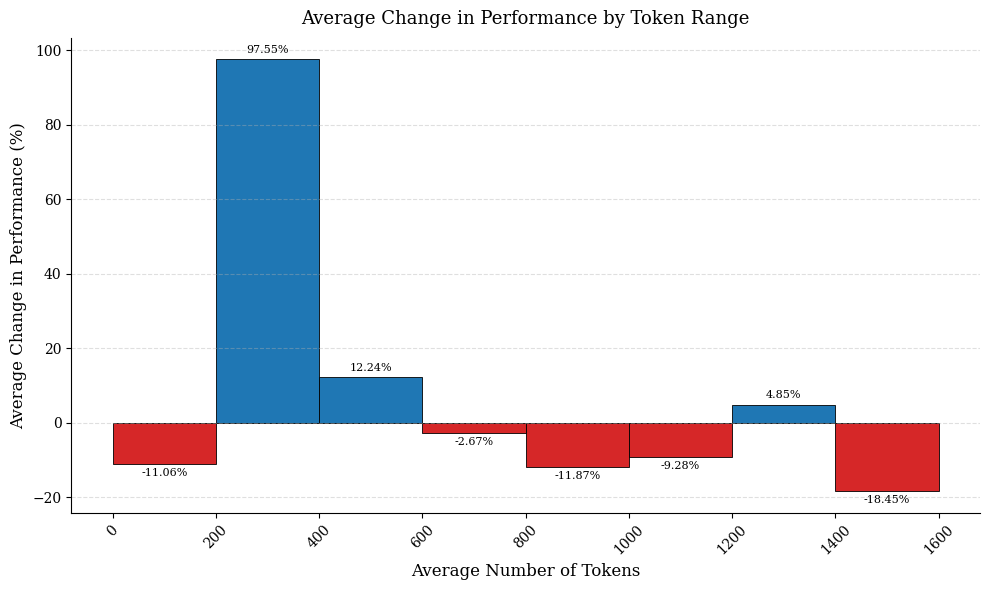

In [134]:
import matplotlib.pyplot as plt

# Original average relative differences (in %)
orig_avg = avg_rel_diff

# Flip signs to represent drop in performance
avg_drop = {k: -v for k, v in orig_avg.items()}

# Define bins
bins = list(range(0, 1701, 200))

# Apply publication‐ready styling
plt.rcParams.update({
    "font.family": "serif",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

# Prepare x (left edges) and y (flipped values)
x = bins[:-1]
y = [avg_drop[f"token_{bins[i]}_{bins[i+1]}"] for i in range(len(x))]

# Use Matplotlib's muted blues and reds (tab:blue and tab:red)
blue = '#1f77b4'
red  = '#d62728'
colors = [blue if val >= 0 else red for val in y]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    x,
    y,
    width=200,
    align='edge',
    edgecolor='black',
    color=colors,
    linewidth=0.6
)

# Add exact value labels
ax.bar_label(bars, padding=3, fontsize=8, fmt="%.2f%%")

# Labels and title
ax.set_xlabel("Average Number of Tokens")
ax.set_ylabel("Average Change in Performance (%)")
ax.set_title("Average Change in Performance by Token Range", fontsize=13, pad=10)

# Clean up spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='out')

# Grid for readability
ax.grid(axis='y', linestyle='--', alpha=0.4)

# X-axis ticks
ax.set_xticks(bins)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


___

### Get the Models Used in Each Part



In [135]:
root_dir = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/result_1/1-1.ADE-ADE identification"


os.listdir(root_dir)

['Mistral-Small-3.1-24B-Instruct-2503',
 'MeLLaMA-13B-chat',
 'MeLLaMA-70B-chat',
 'gemma-3-12b-it',
 'QWQ-32B',
 '.DS_Store',
 'DeepSeek-R1-Distill-Qwen-7B',
 'DeepSeek-R1-Distill-Qwen-1.5B',
 'gemini-1.5-pro',
 'DeepSeek-R1',
 'DeepSeek-R1-Distill-Llama-8B',
 'DeepSeek-R1-Distill-Llama-70B',
 'Mistral-Small-24B-Instruct-2501',
 'Baichuan-M1-14B-Instruct',
 'DeepSeek-R1-Distill-Qwen-14B',
 'DeepSeek-R1-Distill-Qwen-32B',
 'gemma-3-4b-it',
 'gemma-3-27b-it',
 'gemma-3-1b-it',
 'Llama-4-Scout-17B-16E-Instruct',
 'gemini-2.0-flash']

In [ ]:
root_dir = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/combined_results/1-1.ADE-ADE identification"
dir_0 = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/result_0/1-1.ADE-ADE identification"
dir_1 = "/Users/kevinxie/Library/CloudStorage/GoogleDrive-kevinxie2024@gmail.com/My Drive/cot-analysis/result_1/1-1.ADE-ADE identification"

ls0 = os.listdir(dir_0)
ls1 = os.listdir(dir_1)


combined = os.listdir(root_dir)

for model in combined:
    if model == ".DS_Store":
        continue
    print(len(os.listdir(root_dir + '/' + model)))
    if len(os.listdir(root_dir + '/' + model)) == 6:
        print(model)


In [144]:
all_folders

['12.C-EMRS',
 '17-1.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-CM',
 '17-2.CLEF_eHealth_2020_CodiEsp_corpus-ICD-10-PCS',
 '19.ClinicalNotes-UPMC',
 '20.clinical records from the Mexican Social Security Institute',
 '21.CLINpt',
 '22.CLIP',
 '23.cMedQA',
 '26.DialMed',
 '27.DiSMed',
 '28.MIE',
 '29.EHRQA.sub_department',
 '29.EHRQA.qa',
 '29.EHRQA.primary_department',
 '31.Ex4CDS',
 '33.GOUT-CC.consensus',
 '35.n2c2 2006 - De-identification',
 '37.i2b2-2009-Medication-Extraction-Challenge',
 '38-1.i2b2-2010-Relations-Challenge-concept',
 '38-3.i2b2-2010-Relations-Challenge-relation',
 '38-2.i2b2-2010-Relations-Challenge-assertion',
 '40-1.i2b2-2012-Temporal-Relations-Challenge-event',
 '40-2.i2b2-2012-Temporal-Relations-Challenge-time',
 '40-3.i2b2-2012-Temporal-Relations-Challenge-relation',
 '41.n2c2 2014 - De-identification',
 '43.IMCS-V2-NER',
 '46.Japanese Case Reports',
 '48.meddocan',
 '51.MEDIQA_2019_Task2_RQE',
 '55.MedNLI',
 '57.MedSTS',
 '62.mtsamples',
 '63.MTSamples-temporal 